In [1]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 76.6 MB 1.2 MB/s 


In [3]:
import pandas as pd
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import TimeSeriesSplit,  train_test_split, RandomizedSearchCV, GridSearchCV 
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.dummy import DummyRegressor
from sklearn.preprocessing import StandardScaler

from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

import time

import warnings
warnings.filterwarnings('ignore')

In [4]:
# напишем общую функцию для распаковки данных

def open_data(data):
  display(data.head(5))
  print('-------------------------------')
  print('Общая информация')
  data.info()
  print('-------------------------------')
  print('Описание данных')
  display(data.describe())
  print('-------------------------------')
  print('Количество пропусков')
  print(data.isna().sum())

## Подготовка

In [5]:
# выгрузим данные 
data = pd.read_csv('/content/drive/My Drive/Collab file/taxi.csv', index_col=[0], parse_dates=[0])
data.sort_index(inplace=True)

In [6]:
open_data(data)

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


-------------------------------
Общая информация
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB
-------------------------------
Описание данных


,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


-------------------------------
Количество пропусков
num_orders    0
dtype: int64


In [7]:
#проверим, монотонный ли индекс

print(data.index.is_monotonic)

True


### Краткий итог

- выгрузили данные и отсортировали индексы.
- перед нами данные с 1 марта 2018 года по 31 августа 2018 года.
- посмотрели на описание данных, пропусков нет.
- проверили ряд на монотонность, порядок соблюден.

## Анализ

In [8]:
#скопируем датафрейм для дальнейшего анализа

data_copy = data.copy()

In [9]:
#сделаем ресемплинг по одному часу

data_copy = data_copy.resample('1H').sum()

In [10]:
#сделаем декомпозицию

decomposed = seasonal_decompose(data_copy['num_orders'])

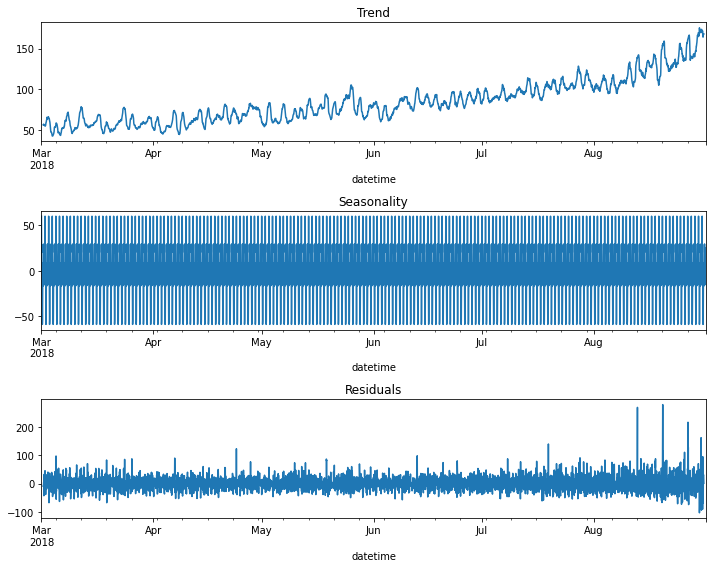

In [11]:
#построим графики

plt.figure(figsize=(10, 8))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca()) 
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

На графиках мы наблюдаем возрастающий тренд, а также ежедневную сезонность. Посмотрим графики более усеченные, возьмем, например, за одну неделю. Интересно было бы посмотреть на последнюю неделю июля, так как в августе появился резкий скачок. А далее можно сравнить с первой неделей августа.

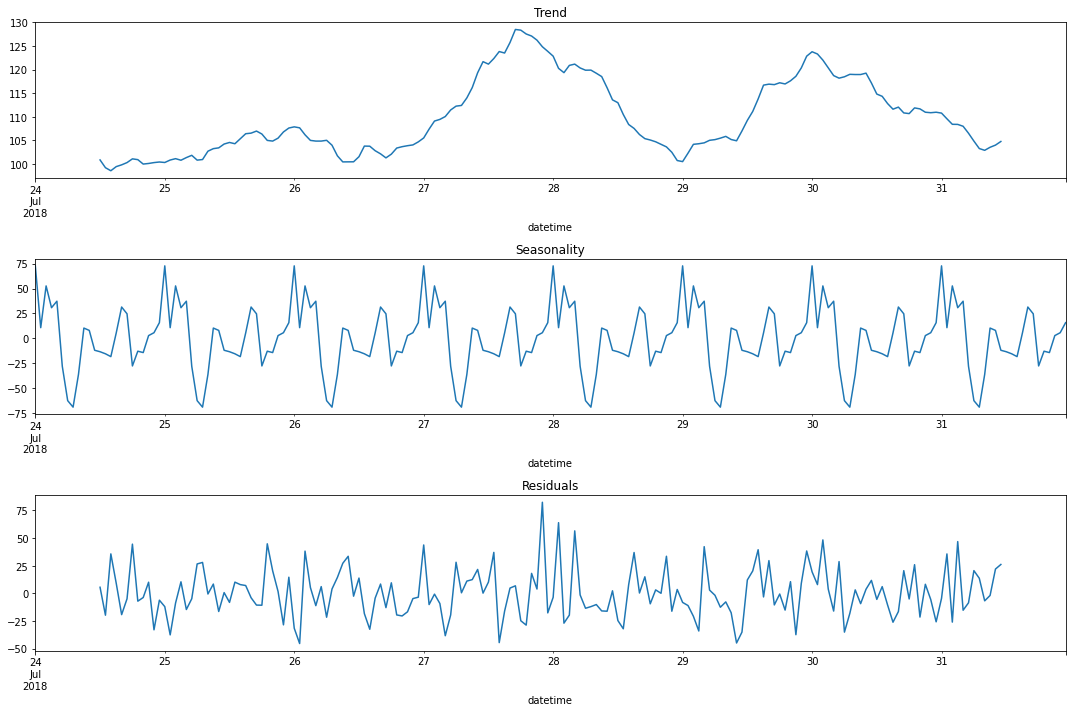

In [12]:
#последняя неделя июля

decomposed = seasonal_decompose(data_copy['2018-07-24':'2018-07-31'])


plt.figure(figsize=(15, 10))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca()) 
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

Тренд в течение недели сильно меняется. 27-29 это выходные дни (вместе с пятницей).
Сезонность цикличная.

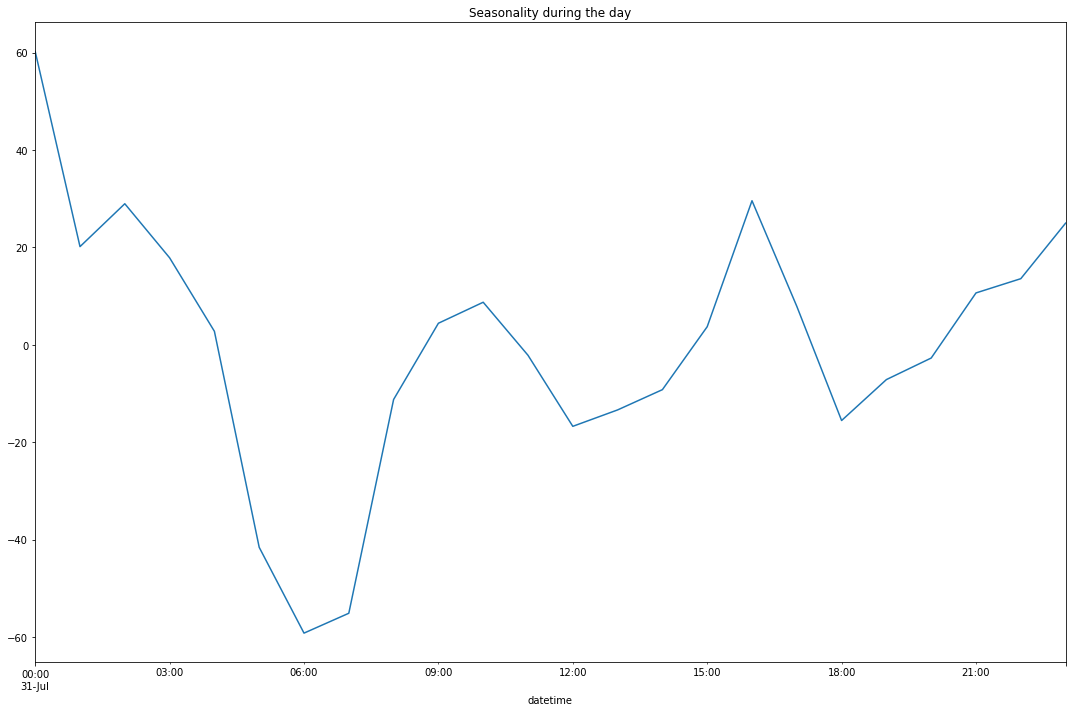

In [13]:
#посмотрим на сезонность последнего дня

decomposed = seasonal_decompose(data_copy)

plt.figure(figsize=(15, 10))
decomposed.seasonal['2018-07-31 00:00:00':'2018-07-31 23:00:00'].plot(ax=plt.gca()) 
plt.title('Seasonality during the day')
plt.tight_layout()

Мы видим спад в 6 утра, так как, по всей видимости, активность большая из-за ночных рейсов. В 15:00 мы наблюдаем пик заказов, однако, он все равно меньше, чем в ночное время.

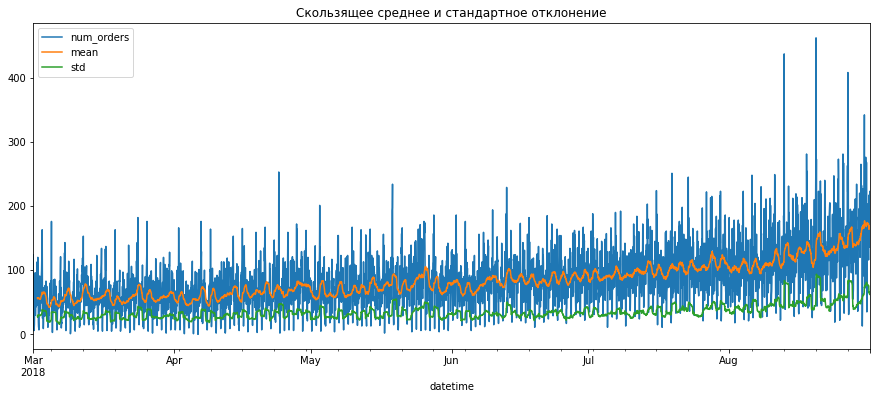

In [14]:
#построим график скользящего среднего, заодно посмотрим на стандартное отклонение


data_copy['mean'] = data_copy['num_orders'].rolling(24).mean()
data_copy['std'] = data_copy['num_orders'].rolling(24).std()

data_copy.plot(title='Скользящее среднее и стандартное отклонение', figsize=(15,6))

Можно наблюдать достаточное количество выбросов, хоть мы и сгладили данные, и практически все они приходятся на конец месяцов, в мае активность увеличивается в начале, предполагаю из-за праздников. В августе вообще довольно много выбросов, в августе принято ездить в отпуск (в основном). Среднее постепенно увеличивается почти на всем периоде.

Проведем тест Дики-Фуллера, чтобы понять стационарный перед нами ряд стационарный или нет.

- H0 - Временной ряд является нестационарным
- H1 - Временной ряд является стационарным

In [15]:
p_value = adfuller(data['num_orders'])[1]
print('P =', p_value)

if p_value < 0.05:
    print('Нулевая гипотеза отвергается. Ряд стационарен по критерию Дики-Фуллера')
else:
    print('Нулевая гипотеза не отвергается. Ряд нестационарен по критерию Дики-Фуллера')

P = 2.2286378815479788e-23
Нулевая гипотеза отвергается. Ряд стационарен по критерию Дики-Фуллера


### Краткий итог

- Для проведения анализа был скопирован датафрейм, чтобы не вносить изменения в основной.
- Был выполнен ресемплинг по 1 часу.
- Сделали декомпозицию и построили графики по общим данным. Наблюдался возрастающий тренд и ежедневная сезонность.
- Были взяты более маленькие периоды для наглядности - последняя неделя июля и последний день августа. Такие промежутки были выбраны, потому что в августе наблюдался большой прирост в заказах. Было интересно посмотреть, как распределились данные перед этим взлетом.
- Декомпозиция последней недели показала, что тренд сильно менялся в течение всей недели, наблюдаем увеличение на выходных.
- Декомпозиция последнего дня показала, что сезонность сильно меняется в течение всего дня - увеличиние количества заказов в ночное время и обед.
- Скользящее среднее и стандартное отклонение - много выбросов, среднее значение постепенно увеличивается к концу августа.
- Проверили стационарность ряда, ряд стационарный, с ним можно работать.

## Обучение

### Подготовка признаков

In [16]:
#разделим данные на признаки и целевой признак
#для этого напишем функцию, чтобы прибавить к таблице доп. признаки - час и день недели

data = data.resample('1H').sum()

def make_features(data, max_lag, rolling_mean_size):
    data['day_of_week'] = data.index.dayofweek
    data['hour'] = data.index.hour
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data.iloc[:,0].shift(lag)

    data['rolling_mean'] = data.iloc[:,0].shift().rolling(rolling_mean_size).mean()

make_features(data, 9, 9)

data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   num_orders    4416 non-null   int64  
 1   day_of_week   4416 non-null   int64  
 2   hour          4416 non-null   int64  
 3   lag_1         4415 non-null   float64
 4   lag_2         4414 non-null   float64
 5   lag_3         4413 non-null   float64
 6   lag_4         4412 non-null   float64
 7   lag_5         4411 non-null   float64
 8   lag_6         4410 non-null   float64
 9   lag_7         4409 non-null   float64
 10  lag_8         4408 non-null   float64
 11  lag_9         4407 non-null   float64
 12  rolling_mean  4407 non-null   float64
dtypes: float64(10), int64(3)
memory usage: 483.0 KB


In [17]:
#теперь переходим к признакам

train, test = train_test_split(data, shuffle=False, test_size=0.1)
train = train.dropna()

In [18]:
#определим признаки и целевой признак

features_train = train.drop(['num_orders'], axis=1)
features_test = test.drop(['num_orders'], axis=1)

target_train = train['num_orders']
target_test = test['num_orders']

print('Обучающая выборка: ', features_train.shape,  target_train.shape)
print('Тестовая выборка: ', features_test.shape,  target_test.shape)

Обучающая выборка:  (3965, 12) (3965,)
Тестовая выборка:  (442, 12) (442,)


### Краткий итог

- Добавили в датафрейм календарные признаки как отдельные столбцы.
- Вычислили отстающие значения.
- Вычислили скользящее среднее и добавили его в датафрейм как отдельные колонки.
- Определили целевой признак и признаки для обучающей и тестовой выборок в соотношении: 90% обучающая выборка, 10% тестовая.

### Обучение моделей

Обучим три модели:

- Линейная регрессия
- CatBoost
- LGBMRegressor

In [19]:
# для наглядности результатов сведем после обучения полученные метрики в таблицу

def metrics(rmse, fit_time, pred_time, model, data):
    data.loc[model, 'RMSE'] = rmse
    data.loc[model, 'time_fit'] = fit_time
    data.loc[model, 'time_pred'] = pred_time
    return data

In [20]:
# таблица для сравнения результатов обучения моделей

compare_models = pd.DataFrame(columns=['RMSE', 'time_fit', 'time_pred'])

In [21]:
%%time

#сделаем константную модель для сравнения с нашими моделями

dummy = DummyRegressor()
dummy_model = dummy.fit(features_train, target_train)

dummy_pred_test = dummy_model.predict(features_test)

rmse_dummy = mean_squared_error(target_test, dummy_pred_test)**0.5

print('RMSE для константной модели на тестовой выборке: {:.2f}'.format(rmse_dummy))

RMSE для константной модели на тестовой выборке: 84.70
CPU times: user 3.02 ms, sys: 0 ns, total: 3.02 ms
Wall time: 2.97 ms


#### Линейная регрессия

In [22]:
%%time

#обучим модель без подборки гипперпараметров 
start = time.time()
model_lr = LinearRegression()
model_lr.fit(features_train, target_train)
end = time.time()
fit_time_lr = end - start

CPU times: user 9.98 ms, sys: 0 ns, total: 9.98 ms
Wall time: 22 ms


In [23]:
%%time
start = time.time()
prediction = model_lr.predict(features_test)
end = time.time()
pred_time_lr = end - start
rmse_lr = mean_squared_error(prediction, target_test) ** 0.5

print('RMSE для Линейной регрессии на тестовой выборке: {:.2f}'.format(rmse_lr))

RMSE для Линейной регрессии на тестовой выборке: 54.09
CPU times: user 5.67 ms, sys: 2.97 ms, total: 8.64 ms
Wall time: 15.1 ms


#### CatBoostRegressor

In [24]:
cb_features = ['day_of_week', 'hour']

In [25]:
%%time

#подберем наилучшие параметры с помощью кросс-валидации

my_cv = TimeSeriesSplit(n_splits=3).split(features_train)

model_cb = CatBoostRegressor(iterations=100, verbose=False, cat_features = cb_features)
params_cb = {'learning_rate':[0.1, 0.3, 0.5], 'depth':[5,10, 15]}

random_cb = RandomizedSearchCV(model_cb, params_cb, scoring='neg_mean_squared_error',  cv=my_cv, n_jobs = -1)
random_cb.fit(features_train, target_train)

rmse=(-random_cb.best_score_)**0.5

print('RMSE модели CatBoost на обучающей выборке:{:.2f}'.format(rmse))
print('Лучшие гиперпараметры для модели: ', random_cb.best_params_)

RMSE модели CatBoost на обучающей выборке:28.04
Лучшие гиперпараметры для модели:  {'learning_rate': 0.1, 'depth': 5}
CPU times: user 6.95 s, sys: 871 ms, total: 7.82 s
Wall time: 15min 1s


In [26]:
%%time

#обучим модель с подобранными параметрами
start = time.time()
model_cb_best = CatBoostRegressor(iterations=100, verbose=False, cat_features = cb_features, 
                        learning_rate=0.1, depth=5)
model_cb_best.fit(features_train, target_train)
end = time.time()
fit_time_cb = end - start

CPU times: user 489 ms, sys: 47.6 ms, total: 537 ms
Wall time: 316 ms


In [27]:
%%time
start = time.time()
model_cb_best_pred = model_cb_best.predict(features_test)
end = time.time()
pred_time_cb = end - start
rmse_cb = mean_squared_error(target_test, model_cb_best_pred)**0.5
print('RMSE для CatBoost на тестовой выборке: {:.2f}'.format(rmse_cb))

RMSE для CatBoost на тестовой выборке: 43.76
CPU times: user 3.99 ms, sys: 3.1 ms, total: 7.09 ms
Wall time: 6.71 ms


#### LGBMRegressor

In [28]:
%%time

#подберем наилучшие параметры с помощью кросс-валидации

my_cv2 = TimeSeriesSplit(n_splits=3).split(features_train)

model_lgmr = LGBMRegressor(random_state=45)
params_lgmr = {'max_depth': [2, 4, 6], 'learning_rate': [0.03, 0.1], 'n_estimators': [50, 100, 200, 500, 1000]}

random_lgmr = RandomizedSearchCV(model_lgmr, params_lgmr, scoring='neg_mean_squared_error', cv=my_cv2)
random_lgmr.fit(features_train, target_train, verbose=True)

rmse=(-random_lgmr.best_score_)**0.5

print('RMSE модели LightGBM на обучающей выборке:{:.2f}'.format(rmse))
print('Лучшие гиперпараметры для модели: ', random_lgmr.best_params_)

RMSE модели LightGBM на обучающей выборке:27.93
Лучшие гиперпараметры для модели:  {'n_estimators': 500, 'max_depth': 4, 'learning_rate': 0.03}
CPU times: user 6.71 s, sys: 199 ms, total: 6.91 s
Wall time: 3.59 s


In [29]:
%%time

#обучим модель с подобранными параметрами
start = time.time()
model_lgmr_best = LGBMRegressor(max_depth = 2, learning_rate = 0.1, n_estimators = 500)
model_lgmr_best.fit(features_train, target_train, verbose = True)
end = time.time()
fit_time_lgmr = end - start

CPU times: user 263 ms, sys: 1.82 ms, total: 265 ms
Wall time: 141 ms


In [30]:
%%time
start = time.time()
model_lgmr_best_pred = model_lgmr_best.predict(features_test)
end = time.time()
pred_time_lgmr = end - start
rmse_lgmr = mean_squared_error(target_test, model_lgmr_best_pred)**0.5
print('RMSE для LightGBM на тестовой выборке: {:.2f}'.format(rmse_lgmr))

RMSE для LightGBM на тестовой выборке: 43.29
CPU times: user 19 ms, sys: 1.56 ms, total: 20.6 ms
Wall time: 15.8 ms


### Краткий итог

- Была создана константная модель для проверки адекватности моделей.
- Было проведено обучение трех моделей: Линейная регрессия, CatBoostRegressor, LGBMRegressor.
- Была проведена кросс-валидация для CatBoostRegressor, LGBMRegressor.
- Были выявлены метрики RMSE на тестовых выборках для всех моделях, поэтому в следующем разделе проведем сравнение метрик и выберем наилучшую модель.

## Тестирование

In [31]:
# сравним полученные результаты

metrics('{:.2f}'.format(rmse_lr), '{:.2f}'.format(fit_time_lr), '{:.2f}'.format(pred_time_lr), 'LinearRegression', compare_models)
metrics('{:.2f}'.format(rmse_cb), '{:.2f}'.format(fit_time_cb), '{:.2f}'.format(pred_time_cb), 'CatBoostRegressor', compare_models)
metrics('{:.2f}'.format(rmse_lgmr), '{:.2f}'.format(fit_time_lgmr), '{:.2f}'.format(pred_time_lgmr), 'LGBMRegressor', compare_models).sort_values(by='RMSE', ascending=True)

,RMSE,time_fit,time_pred
LGBMRegressor,43.29,0.14,0.01
CatBoostRegressor,43.76,0.32,0.01
LinearRegression,54.09,0.02,0.01


## Итог по проекту

- Данные были проанализированы - проведен ресемплинг по одному часу, была сделана декомпозиция и были представлены графики с различными срезами данных. Была проверка ряда на стационарность.
- Подготовили признаки перед обучением моделей. Выборки были поделены следующим образом: 90% - обучающая выборка, 10% - тестовая.
- Перед обучением моделей была создана константная модель.
- Модели, которые были обучены: Линейная регрессия, CatBoostRegressor, LGBMRegressor
- Была сделана таблица для сравнения показателей по всем моделям.
- Наилучший показатель RMSE представила модель LGBMRegressor, хотя ее показатель не сильно отличается от CatBoostRegressor. Наихудший показатель получился у Линейной регрессии. Все модели выдали показатель меньше, чем константная модель, что дает нам понять, что наши модели прошли проверку на адекватность.
- Самое быстрое время обучения у Линейной регрессии, очевидно такое время ей дало отсутствие дополнительных гипперпараметров.
- Время предсказания у всех моделей одинаковое.

По итогу проекта я бы рекомендовала модель LGBMRegressor, так как:

- Метрика RMSE немного больше, чем у CatBoostRegressor, но разница совсем минимальная. Результат отвечает поставленной задаче.
- Подбор гипперпараметров у нее достаточно быстрый, если понадобиться менять параметры модели, то она справится быстрее, чем CatBoostRegressor.
- Скорость обучения у нее также лучше.

Данная модель отвечает требованиям задачи. Так как обычно важна и сама метрика, и скорость подбора параметров, и скорость обучения, то, на мой взгляд, эта модель является самой подходящей.